In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
from tqdm import tqdm
import multiprocessing
import torch.optim as optim
import torch.nn.functional as  F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from main import G_dataset, G_trainer

In [3]:
# Load
x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')

y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

# Stats
print(x_train.shape)
print(y_train.shape)
print(sum(y_train == 1))
print(sum(y_train == 0))
print("{:.4f}".format(sum(y_train == 1)/y_train.shape[0]))
print(x_test.shape)
print(y_test.shape)
print(sum(y_test == 1))
print(sum(y_test == 0))
print("{:.4f}".format(sum(y_test == 1)/y_test.shape[0]))

(10585, 100, 100, 3)
(10585,)
2381
8204
0.2249
(2648, 100, 100, 3)
(2648,)
596
2052
0.2251


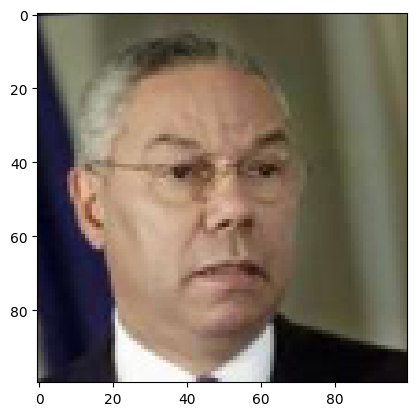

In [4]:
## View some images
plt.imshow(x_train[0,:,:,: ] )
plt.show()

In [5]:
## Transforms
# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')

# y_train = y_train.astype('float32')
# y_test = y_test.astype('float32')


# x_train /= 255
# x_test /= 255

# print(x_train.shape)
# print(x_test.shape)

da_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    # transforms.RandomAffine(degrees=5, translate=(0.2, 0.2)),
    transforms.ToTensor(),
])

train_dataset = G_dataset(x_train, y_train, transform=da_train)
test_dataset = G_dataset(x_test, y_test)
####################################################################
# DataLoader Class
####################################################################

batch_size = 128
num_workers = multiprocessing.cpu_count()-1
print("Num workers", num_workers)
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=num_workers)

Num workers 11


In [6]:
train_dataset.__getitem__(1)

{'img': tensor([[[0.7529, 0.7843, 0.8039,  ..., 0.1255, 0.1137, 0.1529],
          [0.7569, 0.7843, 0.8078,  ..., 0.1176, 0.1098, 0.1647],
          [0.7647, 0.7882, 0.8000,  ..., 0.1059, 0.1137, 0.2000],
          ...,
          [0.1294, 0.1333, 0.1294,  ..., 0.2078, 0.2118, 0.2078],
          [0.1569, 0.1451, 0.1333,  ..., 0.2078, 0.2078, 0.2078],
          [0.1608, 0.1529, 0.1137,  ..., 0.2000, 0.2000, 0.2039]],
 
         [[0.7412, 0.7725, 0.7961,  ..., 0.1059, 0.0980, 0.1373],
          [0.7451, 0.7725, 0.8000,  ..., 0.0980, 0.0941, 0.1490],
          [0.7529, 0.7725, 0.8039,  ..., 0.1059, 0.1020, 0.1843],
          ...,
          [0.1373, 0.1412, 0.1412,  ..., 0.2392, 0.2392, 0.2392],
          [0.1529, 0.1412, 0.1451,  ..., 0.2392, 0.2392, 0.2392],
          [0.1529, 0.1412, 0.1255,  ..., 0.2471, 0.2471, 0.2510]],
 
         [[0.7686, 0.8000, 0.8157,  ..., 0.0157, 0.0000, 0.0314],
          [0.7725, 0.8000, 0.8196,  ..., 0.0039, 0.0000, 0.0314],
          [0.7804, 0.8039, 0.8000

In [7]:

class BinaryCNN(nn.Module):
    def __init__(self):
        super(BinaryCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # (100x100) -> (100x100)
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), # (100x100)
            nn.ReLU(),
            nn.MaxPool2d(2),                             # -> (50x50)

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # (50x50)
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), # (50x50)
            nn.ReLU(),
            nn.MaxPool2d(2),                          # -> (25x25)
            nn.MaxPool2d(2)                             # -> (12x12)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                                # -> (64 * 12 * 12)
            nn.Dropout(0.5),
            nn.Linear(64 * 12 * 12, 1)                    # Salida binaria
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
# Instantiating the network and printing its architecture
net = BinaryCNN()
print(net)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Params: ", count_parameters(net))

####################################################################
# Training settings
####################################################################

# Training hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pos_weight = torch.tensor([4.0], device=device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, weight_decay=1e-6, momentum=0.9)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True, min_lr=1e-5)

epochs = 100

BinaryCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=9216, out_features=1, bias=True)
  )
)
Params:  74785


/home/diego/.cache/pypoetry/virtualenvs/vc-J_2a3VKh-py3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [9]:

trainer = G_trainer(net, train_dataloader, test_dataloader, optimizer,criterion, epochs, lr_scheduler)

In [10]:
trainer.train()


---- Start Training ----


Test 0: 100%|██████████| 21/21 [00:01<00:00, 11.90batch/s]

	LR:  0.01
[Epoch 1] Train Loss: 0.004256 - Test Loss: 0.004371 - Train Accuracy: 76.69% - Test Accuracy: 77.49%



Test 1: 100%|██████████| 21/21 [00:01<00:00, 11.42batch/s]

	LR:  0.01
[Epoch 2] Train Loss: 0.003940 - Test Loss: 0.003783 - Train Accuracy: 78.08% - Test Accuracy: 80.59%



Test 2: 100%|██████████| 21/21 [00:01<00:00, 11.65batch/s]

	LR:  0.01
[Epoch 3] Train Loss: 0.003610 - Test Loss: 0.003775 - Train Accuracy: 79.49% - Test Accuracy: 78.25%



Test 3: 100%|██████████| 21/21 [00:01<00:00, 11.52batch/s]

	LR:  0.01
[Epoch 4] Train Loss: 0.003336 - Test Loss: 0.003378 - Train Accuracy: 80.72% - Test Accuracy: 81.16%



Test 4: 100%|██████████| 21/21 [00:01<00:00, 11.03batch/s]

	LR:  0.01
[Epoch 5] Train Loss: 0.003001 - Test Loss: 0.002874 - Train Accuracy: 83.09% - Test Accuracy: 85.42%



Test 5: 100%|██████████| 21/21 [00:01<00:00, 11.60batch/s]

	LR:  0.01
[Epoch 6] Train Loss: 0.002414 - Test Loss: 0.002061 - Train Accuracy: 86.97% - Test Accuracy: 90.37%



Test 6: 100%|██████████| 21/21 [00:01<00:00, 11.36batch/s]

	LR:  0.01
[Epoch 7] Train Loss: 0.002033 - Test Loss: 0.001810 - Train Accuracy: 89.68% - Test Accuracy: 91.50%



Test 7: 100%|██████████| 21/21 [00:01<00:00, 11.56batch/s]

	LR:  0.01
[Epoch 8] Train Loss: 0.001913 - Test Loss: 0.001556 - Train Accuracy: 90.31% - Test Accuracy: 92.94%



Test 8: 100%|██████████| 21/21 [00:01<00:00, 11.39batch/s]

	LR:  0.01
[Epoch 9] Train Loss: 0.001754 - Test Loss: 0.001596 - Train Accuracy: 91.34% - Test Accuracy: 93.32%



Test 9: 100%|██████████| 21/21 [00:01<00:00, 11.35batch/s]

	LR:  0.01
[Epoch 10] Train Loss: 0.001621 - Test Loss: 0.001436 - Train Accuracy: 91.95% - Test Accuracy: 93.47%



Test 10: 100%|██████████| 21/21 [00:01<00:00, 11.39batch/s]

	LR:  0.01
[Epoch 11] Train Loss: 0.001555 - Test Loss: 0.001431 - Train Accuracy: 92.26% - Test Accuracy: 93.50%



Test 11: 100%|██████████| 21/21 [00:01<00:00, 10.88batch/s]


	LR:  0.01
[Epoch 12] Train Loss: 0.001468 - Test Loss: 0.001311 - Train Accuracy: 92.74% - Test Accuracy: 94.30%


Test 12: 100%|██████████| 21/21 [00:01<00:00, 11.45batch/s]

	LR:  0.01
[Epoch 13] Train Loss: 0.001430 - Test Loss: 0.001340 - Train Accuracy: 92.94% - Test Accuracy: 93.47%



Test 13: 100%|██████████| 21/21 [00:01<00:00, 11.39batch/s]

	LR:  0.01
[Epoch 14] Train Loss: 0.001394 - Test Loss: 0.001197 - Train Accuracy: 93.05% - Test Accuracy: 94.26%



Test 14: 100%|██████████| 21/21 [00:01<00:00, 11.23batch/s]

	LR:  0.01
[Epoch 15] Train Loss: 0.001379 - Test Loss: 0.001353 - Train Accuracy: 92.96% - Test Accuracy: 93.92%



Test 15: 100%|██████████| 21/21 [00:01<00:00, 11.27batch/s]

	LR:  0.01
[Epoch 16] Train Loss: 0.001314 - Test Loss: 0.001195 - Train Accuracy: 93.49% - Test Accuracy: 94.37%



Test 16: 100%|██████████| 21/21 [00:01<00:00, 11.21batch/s]

	LR:  0.01
[Epoch 17] Train Loss: 0.001265 - Test Loss: 0.001252 - Train Accuracy: 93.61% - Test Accuracy: 93.92%



Test 17: 100%|██████████| 21/21 [00:01<00:00, 11.20batch/s]

	LR:  0.01
[Epoch 18] Train Loss: 0.001243 - Test Loss: 0.001239 - Train Accuracy: 93.89% - Test Accuracy: 94.15%



Test 18: 100%|██████████| 21/21 [00:01<00:00, 11.54batch/s]

	LR:  0.01
[Epoch 19] Train Loss: 0.001223 - Test Loss: 0.001122 - Train Accuracy: 94.03% - Test Accuracy: 94.75%



Test 19: 100%|██████████| 21/21 [00:01<00:00, 11.66batch/s]

	LR:  0.01
[Epoch 20] Train Loss: 0.001177 - Test Loss: 0.001216 - Train Accuracy: 94.23% - Test Accuracy: 94.56%



Test 20: 100%|██████████| 21/21 [00:01<00:00, 11.40batch/s]

	LR:  0.01
[Epoch 21] Train Loss: 0.001184 - Test Loss: 0.001106 - Train Accuracy: 94.32% - Test Accuracy: 95.02%



Test 21: 100%|██████████| 21/21 [00:01<00:00, 10.96batch/s]

	LR:  0.01
[Epoch 22] Train Loss: 0.001156 - Test Loss: 0.001066 - Train Accuracy: 94.14% - Test Accuracy: 95.32%



Test 22: 100%|██████████| 21/21 [00:01<00:00, 10.95batch/s]

	LR:  0.01
[Epoch 23] Train Loss: 0.001133 - Test Loss: 0.001035 - Train Accuracy: 94.63% - Test Accuracy: 95.20%



Test 23: 100%|██████████| 21/21 [00:01<00:00, 11.18batch/s]

	LR:  0.01
[Epoch 24] Train Loss: 0.001092 - Test Loss: 0.001052 - Train Accuracy: 94.62% - Test Accuracy: 95.17%



Test 24: 100%|██████████| 21/21 [00:01<00:00, 11.63batch/s]

	LR:  0.01
[Epoch 25] Train Loss: 0.001049 - Test Loss: 0.001038 - Train Accuracy: 94.90% - Test Accuracy: 95.39%



Test 25: 100%|██████████| 21/21 [00:01<00:00, 11.58batch/s]

	LR:  0.01
[Epoch 26] Train Loss: 0.001066 - Test Loss: 0.001175 - Train Accuracy: 94.63% - Test Accuracy: 94.56%



Test 26: 100%|██████████| 21/21 [00:01<00:00, 11.40batch/s]

	LR:  0.01
[Epoch 27] Train Loss: 0.001049 - Test Loss: 0.001041 - Train Accuracy: 94.82% - Test Accuracy: 95.09%



Test 27: 100%|██████████| 21/21 [00:01<00:00, 11.40batch/s]

	LR:  0.01
[Epoch 28] Train Loss: 0.000999 - Test Loss: 0.001081 - Train Accuracy: 95.02% - Test Accuracy: 95.13%



Test 28: 100%|██████████| 21/21 [00:01<00:00, 11.40batch/s]

	LR:  0.005
[Epoch 29] Train Loss: 0.000969 - Test Loss: 0.001039 - Train Accuracy: 95.39% - Test Accuracy: 95.24%



Test 29: 100%|██████████| 21/21 [00:01<00:00, 11.33batch/s]

	LR:  0.005
[Epoch 30] Train Loss: 0.000937 - Test Loss: 0.000981 - Train Accuracy: 95.50% - Test Accuracy: 95.35%



Test 30: 100%|██████████| 21/21 [00:01<00:00, 10.78batch/s]

	LR:  0.005
[Epoch 31] Train Loss: 0.000890 - Test Loss: 0.000994 - Train Accuracy: 95.53% - Test Accuracy: 95.20%



Test 31: 100%|██████████| 21/21 [00:01<00:00, 11.39batch/s]

	LR:  0.005
[Epoch 32] Train Loss: 0.000867 - Test Loss: 0.000969 - Train Accuracy: 95.60% - Test Accuracy: 95.39%



Test 32: 100%|██████████| 21/21 [00:01<00:00, 11.26batch/s]

	LR:  0.005
[Epoch 33] Train Loss: 0.000854 - Test Loss: 0.000959 - Train Accuracy: 95.93% - Test Accuracy: 95.77%



Test 33: 100%|██████████| 21/21 [00:01<00:00, 11.34batch/s]

	LR:  0.005
[Epoch 34] Train Loss: 0.000859 - Test Loss: 0.000954 - Train Accuracy: 95.78% - Test Accuracy: 95.58%



Test 34: 100%|██████████| 21/21 [00:01<00:00, 11.30batch/s]

	LR:  0.005
[Epoch 35] Train Loss: 0.000849 - Test Loss: 0.000940 - Train Accuracy: 95.88% - Test Accuracy: 95.66%



Test 35: 100%|██████████| 21/21 [00:01<00:00, 11.39batch/s]

	LR:  0.005
[Epoch 36] Train Loss: 0.000857 - Test Loss: 0.000978 - Train Accuracy: 95.67% - Test Accuracy: 95.28%



Test 36: 100%|██████████| 21/21 [00:01<00:00, 11.10batch/s]

	LR:  0.005
[Epoch 37] Train Loss: 0.000808 - Test Loss: 0.000963 - Train Accuracy: 96.03% - Test Accuracy: 95.66%



Test 37: 100%|██████████| 21/21 [00:01<00:00, 11.19batch/s]

	LR:  0.005
[Epoch 38] Train Loss: 0.000828 - Test Loss: 0.000977 - Train Accuracy: 95.96% - Test Accuracy: 95.88%



Test 38: 100%|██████████| 21/21 [00:01<00:00, 11.42batch/s]

	LR:  0.005
[Epoch 39] Train Loss: 0.000815 - Test Loss: 0.000963 - Train Accuracy: 95.84% - Test Accuracy: 95.66%



Test 39: 100%|██████████| 21/21 [00:01<00:00, 11.56batch/s]

	LR:  0.005
[Epoch 40] Train Loss: 0.000794 - Test Loss: 0.000936 - Train Accuracy: 96.07% - Test Accuracy: 95.77%



Test 40: 100%|██████████| 21/21 [00:02<00:00, 10.48batch/s]

	LR:  0.005
[Epoch 41] Train Loss: 0.000795 - Test Loss: 0.000970 - Train Accuracy: 96.26% - Test Accuracy: 95.66%



Test 41: 100%|██████████| 21/21 [00:01<00:00, 11.38batch/s]

	LR:  0.005
[Epoch 42] Train Loss: 0.000788 - Test Loss: 0.000975 - Train Accuracy: 96.18% - Test Accuracy: 95.54%



Test 42: 100%|██████████| 21/21 [00:01<00:00, 11.32batch/s]

	LR:  0.005
[Epoch 43] Train Loss: 0.000786 - Test Loss: 0.000934 - Train Accuracy: 96.02% - Test Accuracy: 95.85%



Test 43: 100%|██████████| 21/21 [00:01<00:00, 11.30batch/s]

	LR:  0.005
[Epoch 44] Train Loss: 0.000753 - Test Loss: 0.000911 - Train Accuracy: 96.39% - Test Accuracy: 95.96%



Test 44: 100%|██████████| 21/21 [00:01<00:00, 11.58batch/s]

	LR:  0.005
[Epoch 45] Train Loss: 0.000737 - Test Loss: 0.000922 - Train Accuracy: 96.40% - Test Accuracy: 96.03%



Test 45: 100%|██████████| 21/21 [00:01<00:00, 11.29batch/s]

	LR:  0.005
[Epoch 46] Train Loss: 0.000775 - Test Loss: 0.000950 - Train Accuracy: 96.19% - Test Accuracy: 95.69%



Test 46: 100%|██████████| 21/21 [00:01<00:00, 11.21batch/s]

	LR:  0.005
[Epoch 47] Train Loss: 0.000759 - Test Loss: 0.000944 - Train Accuracy: 96.44% - Test Accuracy: 95.88%



Test 47: 100%|██████████| 21/21 [00:01<00:00, 11.26batch/s]

	LR:  0.005
[Epoch 48] Train Loss: 0.000753 - Test Loss: 0.000952 - Train Accuracy: 96.44% - Test Accuracy: 95.85%



Test 48: 100%|██████████| 21/21 [00:01<00:00, 11.03batch/s]

	LR:  0.005
[Epoch 49] Train Loss: 0.000752 - Test Loss: 0.000947 - Train Accuracy: 96.17% - Test Accuracy: 95.77%



Test 49: 100%|██████████| 21/21 [00:01<00:00, 11.17batch/s]

	LR:  0.0025
[Epoch 50] Train Loss: 0.000723 - Test Loss: 0.000947 - Train Accuracy: 96.39% - Test Accuracy: 95.88%



Test 50: 100%|██████████| 21/21 [00:01<00:00, 11.27batch/s]

	LR:  0.0025
[Epoch 51] Train Loss: 0.000684 - Test Loss: 0.000948 - Train Accuracy: 96.67% - Test Accuracy: 95.81%



Test 51: 100%|██████████| 21/21 [00:01<00:00, 11.31batch/s]

	LR:  0.0025
[Epoch 52] Train Loss: 0.000660 - Test Loss: 0.000950 - Train Accuracy: 96.88% - Test Accuracy: 95.92%



Test 52: 100%|██████████| 21/21 [00:01<00:00, 11.32batch/s]


	LR:  0.0025
[Epoch 53] Train Loss: 0.000687 - Test Loss: 0.000908 - Train Accuracy: 96.64% - Test Accuracy: 96.15%


Test 53: 100%|██████████| 21/21 [00:01<00:00, 11.34batch/s]

	LR:  0.0025
[Epoch 54] Train Loss: 0.000678 - Test Loss: 0.000918 - Train Accuracy: 96.83% - Test Accuracy: 96.03%



Test 54: 100%|██████████| 21/21 [00:01<00:00, 11.06batch/s]

	LR:  0.0025
[Epoch 55] Train Loss: 0.000668 - Test Loss: 0.000910 - Train Accuracy: 96.81% - Test Accuracy: 95.96%



Test 55: 100%|██████████| 21/21 [00:01<00:00, 11.33batch/s]

	LR:  0.0025
[Epoch 56] Train Loss: 0.000652 - Test Loss: 0.000914 - Train Accuracy: 96.84% - Test Accuracy: 95.85%



Test 56: 100%|██████████| 21/21 [00:01<00:00, 11.45batch/s]

	LR:  0.0025
[Epoch 57] Train Loss: 0.000648 - Test Loss: 0.000923 - Train Accuracy: 96.98% - Test Accuracy: 95.96%



Test 57: 100%|██████████| 21/21 [00:01<00:00, 11.36batch/s]


	LR:  0.0025
[Epoch 58] Train Loss: 0.000659 - Test Loss: 0.000918 - Train Accuracy: 96.82% - Test Accuracy: 96.11%


Test 58: 100%|██████████| 21/21 [00:01<00:00, 11.55batch/s]

	LR:  0.00125
[Epoch 59] Train Loss: 0.000672 - Test Loss: 0.000918 - Train Accuracy: 96.74% - Test Accuracy: 96.00%



Test 59: 100%|██████████| 21/21 [00:01<00:00, 11.58batch/s]

	LR:  0.00125
[Epoch 60] Train Loss: 0.000604 - Test Loss: 0.000915 - Train Accuracy: 96.88% - Test Accuracy: 96.15%



Test 60: 100%|██████████| 21/21 [00:01<00:00, 10.99batch/s]

	LR:  0.00125
[Epoch 61] Train Loss: 0.000633 - Test Loss: 0.000903 - Train Accuracy: 96.81% - Test Accuracy: 96.07%



Test 61: 100%|██████████| 21/21 [00:01<00:00, 11.00batch/s]

	LR:  0.00125
[Epoch 62] Train Loss: 0.000623 - Test Loss: 0.000910 - Train Accuracy: 97.00% - Test Accuracy: 96.19%



Test 62: 100%|██████████| 21/21 [00:01<00:00, 11.43batch/s]

	LR:  0.00125
[Epoch 63] Train Loss: 0.000621 - Test Loss: 0.000889 - Train Accuracy: 96.91% - Test Accuracy: 96.15%



Test 63: 100%|██████████| 21/21 [00:01<00:00, 11.72batch/s]

	LR:  0.00125
[Epoch 64] Train Loss: 0.000605 - Test Loss: 0.000918 - Train Accuracy: 97.14% - Test Accuracy: 96.03%



Test 64: 100%|██████████| 21/21 [00:01<00:00, 11.39batch/s]

	LR:  0.00125
[Epoch 65] Train Loss: 0.000621 - Test Loss: 0.000909 - Train Accuracy: 97.00% - Test Accuracy: 96.07%



Test 65: 100%|██████████| 21/21 [00:01<00:00, 11.66batch/s]

	LR:  0.00125
[Epoch 66] Train Loss: 0.000622 - Test Loss: 0.000905 - Train Accuracy: 97.05% - Test Accuracy: 96.19%



Test 66: 100%|██████████| 21/21 [00:01<00:00, 11.54batch/s]

	LR:  0.00125
[Epoch 67] Train Loss: 0.000603 - Test Loss: 0.000913 - Train Accuracy: 97.00% - Test Accuracy: 96.07%



Test 67: 100%|██████████| 21/21 [00:01<00:00, 11.53batch/s]

	LR:  0.00125
[Epoch 68] Train Loss: 0.000622 - Test Loss: 0.000922 - Train Accuracy: 97.04% - Test Accuracy: 96.26%



Test 68: 100%|██████████| 21/21 [00:01<00:00, 11.70batch/s]

	LR:  0.000625
[Epoch 69] Train Loss: 0.000617 - Test Loss: 0.000903 - Train Accuracy: 96.94% - Test Accuracy: 96.26%



Test 69: 100%|██████████| 21/21 [00:01<00:00, 11.82batch/s]

	LR:  0.000625
[Epoch 70] Train Loss: 0.000606 - Test Loss: 0.000902 - Train Accuracy: 96.90% - Test Accuracy: 96.07%



Test 70: 100%|██████████| 21/21 [00:01<00:00, 11.60batch/s]

	LR:  0.000625
[Epoch 71] Train Loss: 0.000601 - Test Loss: 0.000891 - Train Accuracy: 96.96% - Test Accuracy: 96.15%



Test 71: 100%|██████████| 21/21 [00:01<00:00, 11.41batch/s]

	LR:  0.000625
[Epoch 72] Train Loss: 0.000588 - Test Loss: 0.000891 - Train Accuracy: 97.11% - Test Accuracy: 96.19%



Test 72: 100%|██████████| 21/21 [00:01<00:00, 11.47batch/s]

	LR:  0.000625
[Epoch 73] Train Loss: 0.000586 - Test Loss: 0.000900 - Train Accuracy: 97.35% - Test Accuracy: 96.19%



Test 73: 100%|██████████| 21/21 [00:01<00:00, 11.58batch/s]

	LR:  0.000625
[Epoch 74] Train Loss: 0.000603 - Test Loss: 0.000893 - Train Accuracy: 97.10% - Test Accuracy: 96.15%



Test 74: 100%|██████████| 21/21 [00:01<00:00, 11.53batch/s]

	LR:  0.0003125
[Epoch 75] Train Loss: 0.000600 - Test Loss: 0.000894 - Train Accuracy: 97.00% - Test Accuracy: 96.30%



Test 75: 100%|██████████| 21/21 [00:01<00:00, 11.45batch/s]

	LR:  0.0003125
[Epoch 76] Train Loss: 0.000568 - Test Loss: 0.000896 - Train Accuracy: 97.14% - Test Accuracy: 96.15%



Test 76: 100%|██████████| 21/21 [00:01<00:00, 11.35batch/s]

	LR:  0.0003125
[Epoch 77] Train Loss: 0.000558 - Test Loss: 0.000896 - Train Accuracy: 97.33% - Test Accuracy: 96.11%



Test 77: 100%|██████████| 21/21 [00:01<00:00, 11.60batch/s]

	LR:  0.0003125
[Epoch 78] Train Loss: 0.000534 - Test Loss: 0.000898 - Train Accuracy: 97.24% - Test Accuracy: 96.22%



Test 78: 100%|██████████| 21/21 [00:01<00:00, 11.52batch/s]

	LR:  0.0003125
[Epoch 79] Train Loss: 0.000595 - Test Loss: 0.000902 - Train Accuracy: 97.06% - Test Accuracy: 96.11%



Test 79: 100%|██████████| 21/21 [00:01<00:00, 11.48batch/s]

	LR:  0.0003125
[Epoch 80] Train Loss: 0.000554 - Test Loss: 0.000901 - Train Accuracy: 97.29% - Test Accuracy: 96.22%



Test 80: 100%|██████████| 21/21 [00:01<00:00, 11.57batch/s]

	LR:  0.00015625
[Epoch 81] Train Loss: 0.000566 - Test Loss: 0.000899 - Train Accuracy: 97.10% - Test Accuracy: 96.26%



Test 81: 100%|██████████| 21/21 [00:01<00:00, 11.44batch/s]

	LR:  0.00015625
[Epoch 82] Train Loss: 0.000557 - Test Loss: 0.000899 - Train Accuracy: 97.37% - Test Accuracy: 96.22%



Test 82: 100%|██████████| 21/21 [00:01<00:00, 11.60batch/s]

	LR:  0.00015625
[Epoch 83] Train Loss: 0.000584 - Test Loss: 0.000899 - Train Accuracy: 97.02% - Test Accuracy: 96.30%



Test 83: 100%|██████████| 21/21 [00:01<00:00, 11.42batch/s]

	LR:  0.00015625
[Epoch 84] Train Loss: 0.000609 - Test Loss: 0.000899 - Train Accuracy: 97.08% - Test Accuracy: 96.22%



Test 84: 100%|██████████| 21/21 [00:01<00:00, 11.64batch/s]

	LR:  0.00015625
[Epoch 85] Train Loss: 0.000582 - Test Loss: 0.000895 - Train Accuracy: 97.12% - Test Accuracy: 96.26%



Test 85: 100%|██████████| 21/21 [00:01<00:00, 11.58batch/s]

	LR:  0.00015625
[Epoch 86] Train Loss: 0.000575 - Test Loss: 0.000896 - Train Accuracy: 96.99% - Test Accuracy: 96.22%



Test 86: 100%|██████████| 21/21 [00:01<00:00, 11.70batch/s]

	LR:  7.8125e-05
[Epoch 87] Train Loss: 0.000582 - Test Loss: 0.000901 - Train Accuracy: 97.14% - Test Accuracy: 96.15%



Test 87: 100%|██████████| 21/21 [00:01<00:00, 11.70batch/s]

	LR:  7.8125e-05
[Epoch 88] Train Loss: 0.000591 - Test Loss: 0.000899 - Train Accuracy: 97.30% - Test Accuracy: 96.15%



Test 88: 100%|██████████| 21/21 [00:01<00:00, 11.61batch/s]

	LR:  7.8125e-05
[Epoch 89] Train Loss: 0.000592 - Test Loss: 0.000897 - Train Accuracy: 97.13% - Test Accuracy: 96.15%



Test 89: 100%|██████████| 21/21 [00:01<00:00, 11.52batch/s]

	LR:  7.8125e-05
[Epoch 90] Train Loss: 0.000541 - Test Loss: 0.000897 - Train Accuracy: 97.37% - Test Accuracy: 96.15%



Test 90: 100%|██████████| 21/21 [00:01<00:00, 11.78batch/s]

	LR:  7.8125e-05
[Epoch 91] Train Loss: 0.000579 - Test Loss: 0.000896 - Train Accuracy: 97.12% - Test Accuracy: 96.30%

Early Stopping at epoch  90

BEST TEST ACCURACY:  96.29909365558912  in epoch  74
